<a href="https://colab.research.google.com/github/Hasasasaki/semeval_2022_task_4/blob/main/model_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [2]:
# !pip install "flash_attn==2.6.3" --no-build-isolation
!pip install deep_translator

## Data processing

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    TrainerCallback,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
from tqdm import tqdm
import random
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter

seed = 42

def reset_seeds(seed=seed):
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    import random
    random.seed(seed)
    import numpy as np
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

    print(f"All random states have been reset with seed {seed}")

reset_seeds()

new_columns = [
    "par_id",      # 1 (integer ID)
    "art_id",      # @@24942188 (article identifier)
    "topic",       # hopeless (PCL category)
    "country",     # ph (country code)
    "text",        # Full text content
    "label"        # 0 (binary label)
]

official_test_columns = [
    "tid",
    "art_id",
    "topic",
    "country",
    "text"
]

# Read main dataset - skip 4 disclaimer rows
df = pd.read_csv(
    "data/dontpatronizeme_pcl.tsv",
    sep="\t",
    header=None,
    skiprows=4,
    names=new_columns,
    on_bad_lines='warn'
)

official_test_df = pd.read_csv(
    "data/task4_test.tsv",
    sep="\t",
    header=None,
    skiprows=0,
    names=official_test_columns,
    on_bad_lines='warn'
)

# Read train/dev splits
train_val_labels = pd.read_csv("data/train_semeval_parids-labels.csv")
test_labels = pd.read_csv("data/dev_semeval_parids-labels.csv")

# Convert string labels to lists
def parse_labels(label_str: str) -> list[int]:
    return [int(x) for x in label_str.strip("[]").replace(" ", "").split(",")]

# Process labels dataframes
for labels_df in [train_val_labels, test_labels]:
    labels_df['labels'] = labels_df['label'].apply(parse_labels)
    labels_df.drop('label', axis=1, inplace=True)

# Join with main data
train_val_df = df.merge(train_val_labels, on="par_id", how="inner")
test_df = df.merge(test_labels, on="par_id", how="inner")

# Add PCL positivity column to both dataframes
train_val_df['pcl_label'] = train_val_df['label'].apply(
    lambda x: 0 if x in {0, 1} else 1)
test_df['pcl_label'] = test_df['label'].apply(
    lambda x: 0 if x in {0, 1} else 1)

train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, shuffle=True)

All random states have been reset with seed 42
   tid      art_id       topic country  \
0  t_0   @@7258997  vulnerable      us   
1  t_1  @@16397324       women      pk   
2  t_2  @@16257812     migrant      ca   
3  t_3   @@3509652     migrant      gb   
4  t_4    @@477506  vulnerable      ca   

                                                text  
0  In the meantime , conservatives are working to...  
1  In most poor households with no education chil...  
2  The real question is not whether immigration i...  
3  In total , the country 's immigrant population...  
4  Members of the church , which is part of Ken C...  


In [4]:
import nltk
# os.environ["TRANSFORMERS_CACHE"] = "/vol/bitbucket/bj321/.cache"
# nltk.data.path.append("/vol/bitbucket/bj321/nltk_data")  # Your custom path
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [6]:
from deep_translator import GoogleTranslator
import concurrent.futures
import time
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine

# Load SentenceBERT model
print("Loading SentenceBERT model...")
model = SentenceTransformer('all-MiniLM-L6-v2')  # Smaller, faster model
# Alternative: model = SentenceTransformer('paraphrase-mpnet-base-v2')  # More accurate but slower

def compute_similarity(original, translated):
    """Compute cosine similarity between original and translated text embeddings"""
    # Get embeddings
    emb1 = model.encode([original])[0]
    emb2 = model.encode([translated])[0]

    # Compute cosine similarity (1 - cosine distance)
    similarity = 1 - cosine(emb1, emb2)
    return similarity

def back_translate_single(item):
    """Process a single text item with similarity filtering"""
    text, label, par_id, source, target, idx, similarity_threshold = item
    try:
        # First translation (source to target)
        translated = GoogleTranslator(source=source, target=target).translate(text)
        time.sleep(0.5)  # Avoid rate limiting

        # Second translation (target back to source)
        back_translated = GoogleTranslator(source=target, target=source).translate(translated)

        # Compute semantic similarity
        similarity = compute_similarity(text, back_translated)

        # Only return translations that maintain semantic similarity
        if similarity >= similarity_threshold:
            return back_translated, label, par_id, idx, similarity, True
        else:
            print(f"Low similarity ({similarity:.3f}) for item {idx}: discarded")
            return text, label, par_id, idx, similarity, False  # Return original text but mark as not augmented

    except Exception as e:
        print(f"Error in item {idx}: {str(e)}")
        return None, None, None, idx, 0.0, False

def back_translate_batch(texts, labels, par_ids, source='en', target='zh-CN', max_workers=5, similarity_threshold=0.75):
    """Process texts in parallel batches with similarity filtering"""
    results = [None] * len(texts)
    labels_out = [None] * len(labels)
    par_ids_out = [None] * len(par_ids)
    similarities = [0.0] * len(texts)
    is_augmented = [False] * len(texts)

    # Create work items
    work_items = [(texts[i], labels[i], par_ids[i], source, target, i, similarity_threshold) for i in range(len(texts))]

    # Process in parallel
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(back_translate_single, item) for item in work_items]

        # Process results as they complete
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            result, label, par_id, idx, similarity, augmented = future.result()
            if result is not None:
                results[idx] = result
                labels_out[idx] = label
                par_ids_out[idx] = par_id
                similarities[idx] = similarity
                is_augmented[idx] = augmented

    # Create DataFrame with results
    result_df = pd.DataFrame({
        'par_id': par_ids_out,
        'original_text': texts,
        'text': results,
        'pcl_label': [int(x) if x is not None else None for x in labels_out],
        'similarity': similarities,
        'is_augmented': is_augmented
    })

    # Filter out None values
    result_df = result_df.dropna(subset=['text'])

    return result_df

# Main processing loop
language_list = ['zh-CN', 'fr', 'ru']
similarity_threshold = 0.75  # Adjust as needed

for language in language_list:
    output_file = f'data/backtrans_data_{language}.csv'

    if not os.path.exists(output_file):
        print(f"Processing language: {language}")

        # Process in chunks to avoid memory issues
        chunk_size = 100
        all_results_df = pd.DataFrame()

        for i in range(0, len(train_df), chunk_size):
            chunk_texts = train_df['text'].iloc[i:i+chunk_size].tolist()
            chunk_labels = train_df['pcl_label'].iloc[i:i+chunk_size].tolist()
            chunk_par_ids = train_df['par_id'].iloc[i:i+chunk_size].tolist()

            print(f"Processing chunk {i//chunk_size + 1}/{len(train_df)//chunk_size + 1}")
            result_df = back_translate_batch(
                chunk_texts,
                chunk_labels,
                chunk_par_ids,
                source='en',
                target=language,
                max_workers=5,
                similarity_threshold=similarity_threshold
            )

            all_results_df = pd.concat([all_results_df, result_df])

            # Save intermediate results
            all_results_df.to_csv(f'data/backtrans_temp_{language}.csv', index=False)

            # Optional: Add a delay between chunks
            time.sleep(2)

        # Save final results
        all_results_df.to_csv(output_file, index=False)

        # Print statistics
        total = len(all_results_df)
        augmented = all_results_df['is_augmented'].sum()
        print(f"Completed {language}: {total} samples processed")
        print(f"Kept {augmented} samples ({augmented/total:.1%}) with similarity ≥ {similarity_threshold}")
        print(f"Average similarity: {all_results_df['similarity'].mean():.3f}")

Loading SentenceBERT model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Hyperparameters

In [7]:
batch_size = 16
lr = 1e-5
n_epochs = 2
betas = (0.9, 0.98)
eps = 1e-6
wd = 1e-2

In [8]:
class PCLDataset(Dataset):
    def __init__(self, dataframe, tokenizer, balance_method='oversample', seed=seed):
        self.tokenizer = tokenizer

         # Split into positive and negative classes
        pos_df = dataframe[dataframe['pcl_label'] == 1]
        neg_df = dataframe[dataframe['pcl_label'] == 0]

        # Balance classes
        if balance_method == 'oversample':
            # Repeat minority class samples
            if len(pos_df) > len(neg_df):
                pos_df, neg_df = neg_df, pos_df
            n_samples = max(len(pos_df), len(neg_df))
            pos_df = pos_df.sample(n_samples, replace=True, random_state=seed)
        elif balance_method == 'undersample':
            # Take minimum number of samples
            n_samples = min(len(pos_df), len(neg_df))
            pos_df = pos_df.sample(n_samples, random_state=seed)
            neg_df = neg_df.sample(n_samples, random_state=seed)
        elif balance_method == 'None':
            pass

        # Combine and shuffle
        balanced_df = pd.concat([pos_df, neg_df]).sample(frac=1, random_state=seed)
        self.texts = balanced_df['text'].tolist()
        self.labels = balanced_df['pcl_label'].tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and datasets
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")

# Load all backtranslation files and combine them
backtrans_files = [
    'data/backtrans_data_de.csv',
    # 'data/backtrans_data_es.csv',
    'data/backtrans_data_fr.csv',
    # 'data/backtrans_data_ru.csv',
    'data/backtrans_data_zh-CN.csv'
]

backtrans_dfs = []
for file in backtrans_files:
    try:
        cur_df = pd.read_csv(file)
        backtrans_dfs.append(cur_df)
        print(f"Loaded {file} with {len(df)} rows")
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Combine all backtranslation dataframes
if backtrans_dfs:
    backtrans_df = pd.concat(backtrans_dfs, ignore_index=True)
    print(f"Combined backtranslation data: {len(backtrans_df)} rows")
else:
    backtrans_df = pd.DataFrame()
    print("No backtranslation data found")

# Create datasets
for col in train_df.columns:
    if col not in backtrans_df.columns:
        backtrans_df[col] = None

backtrans_df = backtrans_df[train_df.columns]
backtrans_df['pcl_label'] = backtrans_df['pcl_label'].astype(int)
augmented_train_df = pd.concat([backtrans_df, train_df], ignore_index=True)
print(augmented_train_df.head())
train_dataset = PCLDataset(augmented_train_df, tokenizer)
val_dataset = PCLDataset(val_df, tokenizer, balance_method='None')
test_dataset = PCLDataset(test_df, tokenizer, balance_method='None')

Loaded data/backtrans_data_de.csv with 10468 rows
Loaded data/backtrans_data_fr.csv with 10468 rows
Loaded data/backtrans_data_zh-CN.csv with 10468 rows
Combined backtranslation data: 20100 rows
   par_id      art_id     topic country  \
0    5825   @@9438566   in-need      au   
1    7171   @@1934487  hopeless      ng   
2     680   @@9525972   in-need      nz   
3    4906  @@22596758   refugee      bd   
4    8180  @@13717053   migrant      ph   

                                                text label labels  pcl_label  
0  It described the local police as under resourc...  None   None          0  
1  The only force that is able to stop it is the ...  None   None          1  
2  The government's plans to return to mass finan...  None   None          0  
3  New figures show that more than 48,000 Rohingy...  None   None          0  
4  He then listed several immigrants, mainly from...  None   None          0  


## Weighted Random Sampler

In [9]:
class WeightedRandomSamplerTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.weights = torch.FloatTensor(self._get_weights())
        self.sampler = WeightedRandomSampler(self.weights, len(self.weights), replacement=True)

    def get_train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.args.train_batch_size, sampler=self.sampler, collate_fn=self.data_collator)

    def _get_weights(self):
        labels = np.array(self.train_dataset.labels)
        class_counts = np.bincount(labels)
        class_weights = 1.0 / np.sqrt(class_counts.astype(np.float32))
        weights = class_weights[labels]
        return weights

train_dataset = PCLDataset(augmented_train_df, tokenizer, 'None')
val_dataset = PCLDataset(val_df, tokenizer, balance_method='None')
test_dataset = PCLDataset(test_df, tokenizer, balance_method='None')

In [10]:
def clean_memory(force_gc=3):
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()

    gc.collect()
    # Add explicit garbage collection after model training
    gc.collect()

    # Add a small delay to allow memory to be properly freed
    time.sleep(1)

    print("Memory cleaned")

def safe_cleanup(trainer=None, model=None):
    """Safely clean up trainer and model to free GPU memory"""
    if trainer is not None:
        # Remove model reference from trainer to avoid double deletion
        if hasattr(trainer, 'model'):
            if hasattr(trainer.model, 'to'):
                trainer.model.to('cpu')
            trainer.model = None

        # Clear any optimizer states that might be on GPU
        if hasattr(trainer, 'optimizer'):
            trainer.optimizer = None

        # Clear any scheduler states
        if hasattr(trainer, 'lr_scheduler'):
            trainer.lr_scheduler = None

        # Delete the trainer
        del trainer

    # Move model to CPU and delete
    if model is not None:
        if hasattr(model, 'to'):
            model.to('cpu')
        del model

    # Run garbage collection
    clean_memory()

def compute_metrics(eval_pred):
    """Calculate classification metrics for Hugging Face Trainer"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.training_history = {"train": [], "eval": []}
        self.best_f1 = 0.0
        self.best_epoch = 0
        self.best_step = 0

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        self.training_history["eval"].append(metrics)
        # Track best F1 score
        if metrics.get("eval_f1", 0) > self.best_f1:
            self.best_f1 = metrics.get("eval_f1", 0)
            self.best_epoch = state.epoch
            self.best_step = state.global_step

    def on_log(self, args, state, control, logs, **kwargs):
        if "loss" in logs:
            self.training_history["train"].append(logs)



def train_model_with_seed(seed, model_name, train_dataset, val_dataset, output_dir):
    reset_seeds(seed)

    # Create a unique output directory for this seed
    seed_output_dir = f"{output_dir}/seed_{seed}"
    os.makedirs(seed_output_dir, exist_ok=True)

    # Load model with seed-specific configuration
    config = AutoConfig.from_pretrained(model_name, num_labels=2)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

    # Training arguments
    training_args = TrainingArguments(
      seed=seed,
      data_seed=seed,
      dataloader_num_workers=0,
      output_dir=seed_output_dir,
      learning_rate=lr,
      per_device_train_batch_size=batch_size,
      per_device_eval_batch_size=batch_size,
      num_train_epochs=n_epochs,
      lr_scheduler_type="cosine",
      optim="adamw_torch_fused",
      adam_beta1=betas[0],
      adam_beta2=betas[1],
      adam_epsilon=eps,
      # weight_decay=wd,
      logging_strategy="epoch",
      eval_strategy="epoch",
      save_strategy="epoch",
      load_best_model_at_end=True,
      bf16=True,
      bf16_full_eval=True,
      push_to_hub=False,
      warmup_ratio=0.1,
      # full_determinism=True
    )

    # Initialize metrics callback
    metrics_callback = MetricsCallback()

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        processing_class=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=compute_metrics,
        callbacks=[metrics_callback],
    )

    # Train the model
    print(f"Training model with seed {seed}...")
    trainer.train()

    # Evaluate on validation set
    eval_results = trainer.evaluate()

    # Save the best model path and its metrics
    best_checkpoint = os.path.join(seed_output_dir, f"checkpoint-{metrics_callback.best_step}")

    result = {
        "seed": seed,
        "f1_score": metrics_callback.best_f1,
        "best_checkpoint": best_checkpoint,
        "eval_results": eval_results,
        "best_epoch": metrics_callback.best_epoch
    }

    # Delete model and trainer to free memory
    print('before clean')
    safe_cleanup(trainer, model)
    print("after clean")
    return result


def predict_with_model(model_path, test_dataset, tokenizer=None):
    """Use Trainer.predict() to get predictions from a model checkpoint"""
    # Load model and tokenizer from checkpoint
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    if tokenizer is None:
        tokenizer = AutoTokenizer.from_pretrained(model_path)

    # Create a temporary trainer for prediction
    training_args = TrainingArguments(
        output_dir="./tmp_predict",
        per_device_eval_batch_size=32,
        report_to="none",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        processing_class=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=compute_metrics,
    )

    # Get predictions
    print(f"Getting predictions from model at {model_path}")
    predictions = trainer.predict(test_dataset)

    # Extract logits and convert to probabilities
    logits = predictions.predictions
    probs = F.softmax(torch.tensor(logits), dim=1).numpy()

    # Get class predictions (0 or 1)
    preds = np.argmax(logits, axis=1)

    return preds, probs

def ensemble_predict(model_paths, test_dataset, tokenizer=None):
    """Combine predictions from multiple models using majority voting"""
    all_predictions = []
    all_probabilities = []

    # Get predictions from each model
    for model_path in model_paths:
        preds, probs = predict_with_model(model_path, test_dataset, tokenizer)
        all_predictions.append(preds)
        all_probabilities.append(probs)

    # Stack predictions for voting
    stacked_preds = np.stack(all_predictions)

    # Majority voting (mode of predictions)
    voted_predictions = []
    for i in range(len(test_dataset)):
        votes = stacked_preds[:, i]
        # Find most common prediction (0 or 1)
        voted_pred = Counter(votes).most_common(1)[0][0]
        voted_predictions.append(voted_pred)

    # Average probabilities
    avg_probs = np.mean(np.stack(all_probabilities), axis=0)

    return np.array(voted_predictions), avg_probs

def train_ensemble(model_name, train_dataset, val_dataset, test_dataset, num_models=10, output_dir=f"ModernBERT_pcl_ft"):
    """Train multiple models with different seeds and create an ensemble"""
    os.makedirs(output_dir, exist_ok=True)

    # Train multiple models with different seeds
    model_results = []
    seeds = list(range(42, 42 + num_models))  # Use seeds 42 to 51

    for seed in seeds:
        result = train_model_with_seed(seed, model_name, train_dataset, val_dataset, output_dir)
        model_results.append(result)
        print(f"Seed {seed} - F1 Score: {result['f1_score']:.4f}")
        clean_memory()

    # Sort models by validation F1 score and select top 3
    model_results.sort(key=lambda x: x['f1_score'], reverse=True)
    top_models = model_results[:3]

    print("\nTop 3 models:")
    for i, model in enumerate(top_models):
        print(f"{i+1}. Seed {model['seed']} - F1 Score: {model['f1_score']:.4f}")

    # Get the checkpoint paths for the top models
    top_model_paths = [model["best_checkpoint"] for model in top_models]

    # Save ensemble metadata
    ensemble_info = {
        "models": [{"seed": m["seed"], "checkpoint": m["best_checkpoint"], "f1_score": m["f1_score"]} for m in top_models],
        "creation_date": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")
    }

    pd.DataFrame(ensemble_info["models"]).to_csv(f"{output_dir}/ensemble_models.csv", index=False)

    # Evaluate ensemble on test set
    print("\nEvaluating ensemble on test set...")
    ensemble_preds, ensemble_probs = ensemble_predict(top_model_paths, test_dataset)

    # Get true labels from test dataset
    true_labels = [item['labels'].item() for item in test_dataset]

    # Calculate metrics
    accuracy = accuracy_score(true_labels, ensemble_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, ensemble_preds, average='binary')

    print(f"Ensemble Test Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Compare with individual model performance
    print("\nComparing with individual model performance:")
    for i, model_path in enumerate(top_model_paths):
        model_preds, _ = predict_with_model(model_path, test_dataset)
        model_accuracy = accuracy_score(true_labels, model_preds)
        model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(true_labels, model_preds, average='binary')

        print(f"Model {i+1} (Seed {top_models[i]['seed']}):")
        print(f"  Accuracy: {model_accuracy:.4f}")
        print(f"  F1 Score: {model_f1:.4f}")
        print(f"  Precision: {model_precision:.4f}")
        print(f"  Recall: {model_recall:.4f}")

    # Create a prediction function for future use
    def predict_with_ensemble(new_dataset):
        """Function to make predictions with the ensemble on new data"""
        return ensemble_predict(top_model_paths, new_dataset)

    return top_model_paths, ensemble_preds, ensemble_probs, predict_with_ensemble

In [11]:
# Define your model name
model_name = "answerdotai/ModernBERT-base"  # or your preferred model
clean_memory()
# Train the ensemble
top_model_paths, ensemble_preds, ensemble_probs, predict_fn = train_ensemble(
    model_name=model_name,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    num_models=10,
)

Memory cleaned
All random states have been reset with seed 42


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model with seed 42...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jiangby03 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.232800,0.214350,0.921791,0.576052,0.635714,0.526627
2,0.084000,0.364406,0.927761,0.584192,0.696721,0.502959


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


before clean
Memory cleaned
after clean
Seed 42 - F1 Score: 0.5842
Memory cleaned
All random states have been reset with seed 43


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model with seed 43...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.225500,0.248499,0.923582,0.475410,0.773333,0.343195
2,0.091700,0.361197,0.924179,0.560554,0.675000,0.479290


before clean
Memory cleaned
after clean
Seed 43 - F1 Score: 0.5606
Memory cleaned
All random states have been reset with seed 44


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model with seed 44...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.220900,0.269232,0.921791,0.427948,0.816667,0.289941
2,0.073400,0.362388,0.925373,0.551971,0.700000,0.455621


before clean
Memory cleaned
after clean
Seed 44 - F1 Score: 0.5520
Memory cleaned
All random states have been reset with seed 45


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model with seed 45...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.215100,0.295227,0.920597,0.419214,0.800000,0.284024
2,0.081800,0.368292,0.918209,0.532423,0.629032,0.461538


before clean
Memory cleaned
after clean
Seed 45 - F1 Score: 0.5324
Memory cleaned
All random states have been reset with seed 46


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model with seed 46...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.236800,0.239904,0.917612,0.551948,0.611511,0.502959
2,0.101700,0.342282,0.917612,0.549020,0.613139,0.497041


before clean
Memory cleaned
after clean
Seed 46 - F1 Score: 0.5519
Memory cleaned
All random states have been reset with seed 47


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model with seed 47...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.226700,0.235260,0.921791,0.501901,0.702128,0.390533
2,0.091000,0.390652,0.915821,0.515464,0.614754,0.443787


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


before clean
Memory cleaned
after clean
Seed 47 - F1 Score: 0.5155
Memory cleaned
All random states have been reset with seed 48


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model with seed 48...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.230900,0.297067,0.918806,0.442623,0.720000,0.319527
2,0.105700,0.340604,0.920000,0.521429,0.657658,0.431953


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


before clean
Memory cleaned
after clean
Seed 48 - F1 Score: 0.5214
Memory cleaned
All random states have been reset with seed 49


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model with seed 49...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.229900,0.240711,0.921791,0.540351,0.663793,0.455621
2,0.085000,0.375680,0.921194,0.544828,0.652893,0.467456


before clean
Memory cleaned
after clean
Seed 49 - F1 Score: 0.5448
Memory cleaned
All random states have been reset with seed 50


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model with seed 50...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.215500,0.315436,0.920000,0.476562,0.701149,0.360947
2,0.080000,0.397128,0.924179,0.557491,0.677966,0.473373


before clean
Memory cleaned
after clean
Seed 50 - F1 Score: 0.5575
Memory cleaned
All random states have been reset with seed 51


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model with seed 51...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.217100,0.239147,0.924776,0.522727,0.726316,0.408284
2,0.077500,0.360248,0.919403,0.529617,0.644068,0.449704


before clean
Memory cleaned
after clean
Seed 51 - F1 Score: 0.5296
Memory cleaned

Top 3 models:
1. Seed 42 - F1 Score: 0.5842
2. Seed 43 - F1 Score: 0.5606
3. Seed 50 - F1 Score: 0.5575

Evaluating ensemble on test set...
Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Ensemble Test Results:
Accuracy: 0.9250
F1 Score: 0.5396
Precision: 0.6479
Recall: 0.4623

Comparing with individual model performance:
Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Model 1 (Seed 42):
  Accuracy: 0.9236
  F1 Score: 0.5556
  Precision: 0.6211
  Recall: 0.5025
Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Model 2 (Seed 43):
  Accuracy: 0.9216
  F1 Score: 0.5119
  Precision: 0.6277
  Recall: 0.4322
Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Model 3 (Seed 50):
  Accuracy: 0.9231
  F1 Score: 0.5165
  Precision: 0.6418
  Recall: 0.4322


In [12]:
!zip -r /content/file.zip /content/ModernBERT_pcl_ft
from google.colab import files
files.download("/content/file.zip")

  adding: content/ModernBERT_pcl_ft/ (stored 0%)
  adding: content/ModernBERT_pcl_ft/seed_42/ (stored 0%)
  adding: content/ModernBERT_pcl_ft/seed_42/checkpoint-1675/ (stored 0%)
  adding: content/ModernBERT_pcl_ft/seed_42/checkpoint-1675/optimizer.pt (deflated 19%)
  adding: content/ModernBERT_pcl_ft/seed_42/checkpoint-1675/training_args.bin (deflated 52%)
  adding: content/ModernBERT_pcl_ft/seed_42/checkpoint-1675/tokenizer.json (deflated 82%)
  adding: content/ModernBERT_pcl_ft/seed_42/checkpoint-1675/special_tokens_map.json (deflated 79%)
  adding: content/ModernBERT_pcl_ft/seed_42/checkpoint-1675/config.json (deflated 58%)
  adding: content/ModernBERT_pcl_ft/seed_42/checkpoint-1675/tokenizer_config.json (deflated 95%)
  adding: content/ModernBERT_pcl_ft/seed_42/checkpoint-1675/trainer_state.json (deflated 56%)
  adding: content/ModernBERT_pcl_ft/seed_42/checkpoint-1675/rng_state.pth (deflated 25%)
  adding: content/ModernBERT_pcl_ft/seed_42/checkpoint-1675/scheduler.pt (deflated 5

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference

In [29]:
import torch
from torch.utils.data import Dataset

class PCLInferenceDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        """
        Dataset class for inference.

        Args:
            dataframe (pd.DataFrame): The input dataframe with a 'text' column.
            tokenizer (transformers.PreTrainedTokenizer): Tokenizer for text processing.
        """
        self.tokenizer = tokenizer
        self.texts = dataframe['text'].tolist()  # Maintain order
        self.ids = dataframe.index.tolist()  # Keep track of original indices (optional)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'index': self.ids[idx]  # Return the original index to track order (optional)
        }

def ensemble_predict_soft(model_paths, test_dataset, tokenizer=None, weights=None):
    all_probabilities = []

    # If no weights are provided, use equal weights for each model
    if weights is None:
        weights = [1.0] * len(model_paths)
    else:
        assert len(weights) == len(model_paths), "The number of weights must equal the number of models."

    # Get probabilities from each model
    for model_path in model_paths:
        _, probs = predict_with_model(model_path, test_dataset, tokenizer)
        all_probabilities.append(probs)

    # Compute weighted average of the probabilities
    weighted_probs = np.stack([w * probs for w, probs in zip(weights, all_probabilities)], axis=0)
    avg_probs = np.sum(weighted_probs, axis=0) / np.sum(weights)

    # Determine final predictions by thresholding the averaged probability at 0.5
    final_preds = (avg_probs > 0.5).astype(int)

    return final_preds, avg_probs


test_inference_dataset = PCLInferenceDataset(test_df, tokenizer)
official_test_inference_dataset = PCLInferenceDataset(official_test_df, tokenizer)
# ensemble_predict(top_model_paths, val_dataset)
val_preds, _ = ensemble_predict_soft(top_model_paths, test_inference_dataset)
val_preds = [0 if p[0] else 1 for p in val_preds]
test_preds, _ = ensemble_predict_soft(top_model_paths, official_test_inference_dataset)
test_preds = [0 if p[0] else 1 for p in test_preds]
true_val_labels = test_df['pcl_label'].tolist()
precision, recall, f1, _ = precision_recall_fscore_support(true_val_labels, val_preds, average='binary')
print(precision, recall, f1)



Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


0.6571428571428571 0.4623115577889447 0.5427728613569321


In [31]:
with open('dev.txt', 'w') as f:
  for p in val_preds:
    f.write(str(p) + '\n')

with open('test.txt', 'w') as f:
  for p in test_preds:
    f.write(str(p) + '\n')

## Model Analysis

In [49]:
import matplotlib.pyplot as plt

def evaluate_ensemble(model_paths, dataset, true_labels, tokenizer=None, weights=None):
  preds, _ = ensemble_predict_soft(model_paths, dataset)
  preds = [0 if p[0] else 1 for p in preds]
  precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='binary')
  return precision, recall, f1

### Level of PCL Analysis

In [48]:
results = []
for i in range(2, 5):
  cur_df = test_df[test_df['label'] == i]
  dataset = PCLInferenceDataset(cur_df, tokenizer=tokenizer)
  labels = cur_df['pcl_label']
  results.append(evaluate_ensemble(top_model_paths, dataset, labels))

Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


[(1.0, 0.05555555555555555, 0.10526315789473684), (1.0, 0.449438202247191, 0.6201550387596899), (1.0, 0.5543478260869565, 0.7132867132867133)]


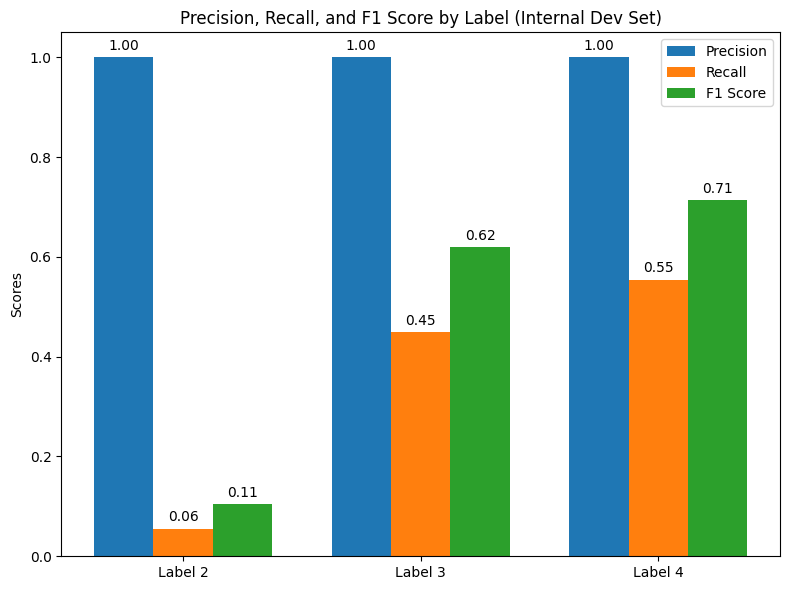

In [56]:
# Define labels for the x-axis
labels = ['Label 2', 'Label 3', 'Label 4']

# Unpack metrics into separate lists for clarity
precisions = [m[0] for m in results]
recalls = [m[1] for m in results]
f1_scores = [m[2] for m in results]

# Set up positions and width for the bars
x = np.arange(len(labels))
width = 0.25

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width, precisions, width, label='Precision')
rects2 = ax.bar(x, recalls, width, label='Recall')
rects3 = ax.bar(x + width, f1_scores, width, label='F1 Score')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score by Label (Internal Dev Set)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to attach a text label above each bar displaying its height
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text by 3 points above the bar
                    textcoords="offset points",
                    ha='center', va='bottom')

# Apply the autolabel function to each set of bars
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Display the plot
plt.tight_layout()
plt.show()

### Text length analysis

Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


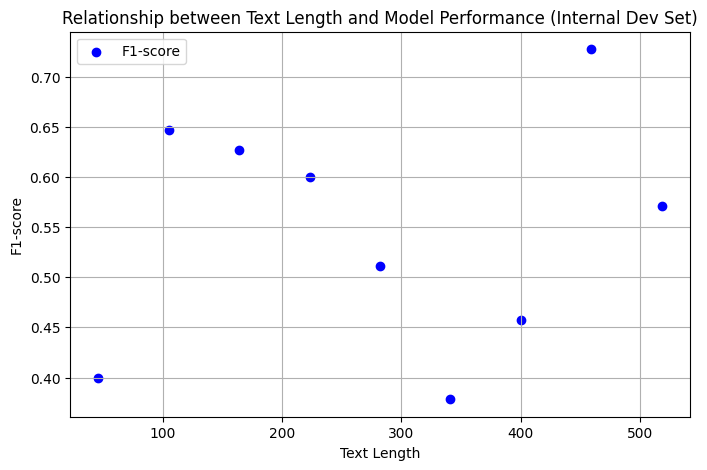

In [57]:
# Compute text lengths
text_lengths = test_df['text'].str.len()

# Remove outliers using the interquartile range (IQR) method
Q1 = np.percentile(text_lengths, 25)
Q3 = np.percentile(text_lengths, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_df = test_df[(text_lengths >= lower_bound) & (text_lengths <= upper_bound)]

# Compute text lengths after outlier removal
filtered_text_lengths = filtered_df['text'].str.len()

# Define bins for text length
bins = np.linspace(filtered_text_lengths.min(), filtered_text_lengths.max(), num=10)
bin_labels = np.digitize(filtered_text_lengths, bins)

# Store F1 scores for each bin
length_f1_scores = []
bin_centers = []

for i in range(1, len(bins)):
    bin_df = filtered_df[(bin_labels == i)]
    if bin_df.empty:
        continue
    dataset = PCLInferenceDataset(bin_df, tokenizer=tokenizer)
    labels = bin_df['pcl_label']
    _, _, f1 = evaluate_ensemble(top_model_paths, dataset, labels)
    length_f1_scores.append(f1)
    bin_centers.append((bins[i] + bins[i-1]) / 2)

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(bin_centers, length_f1_scores, label='F1-score', color='blue')
plt.xlabel('Text Length')
plt.ylabel('F1-score')
plt.title('Relationship between Text Length and Model Performance (Internal Dev Set)')
plt.legend()
plt.grid(True)
plt.show()


Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_42/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_43/checkpoint-3350


Getting predictions from model at ModernBERT_pcl_ft/seed_50/checkpoint-3350


<ipython-input-59-ce39fe9fa75f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topics, y=f1_scores, palette='viridis', ax=ax1)
<ipython-input-59-ce39fe9fa75f>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(topics, rotation=45, ha='right')


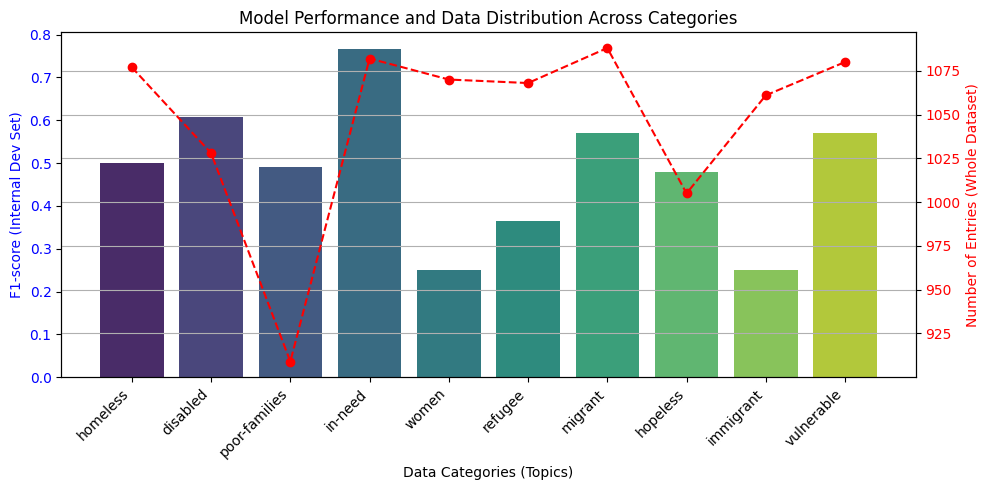

In [59]:
import seaborn as sns

# Analyze model performance by data categories (topics)
topic_f1_scores = {}
topic_counts = {}

for topic in test_df['topic'].unique():
    topic_df = test_df[test_df['topic'] == topic]
    topic_df_full = df[df['topic'] == topic]
    if topic_df.empty:
        continue
    dataset = PCLInferenceDataset(topic_df, tokenizer=tokenizer)
    labels = topic_df['pcl_label']
    _, _, f1 = evaluate_ensemble(top_model_paths, dataset, labels)
    topic_f1_scores[topic] = f1
    topic_counts[topic] = len(topic_df_full)

# Plot results for topic vs F1-score
topics = list(topic_f1_scores.keys())
f1_scores = list(topic_f1_scores.values())
num_entries = [topic_counts[topic] for topic in topics]

fig, ax1 = plt.subplots(figsize=(10, 5))

# Bar plot for F1-score
ax1.set_xlabel('Data Categories (Topics)')
ax1.set_ylabel('F1-score (Internal Dev Set)', color='blue')
sns.barplot(x=topics, y=f1_scores, palette='viridis', ax=ax1)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(topics, rotation=45, ha='right')

# Line plot for number of entries
ax2 = ax1.twinx()
ax2.set_ylabel('Number of Entries (Whole Dataset)', color='red')
ax2.plot(topics, num_entries, marker='o', color='red', linestyle='dashed', label='Number of Entries')
ax2.tick_params(axis='y', labelcolor='red')

# Titles and legend
plt.title('Model Performance and Data Distribution Across Categories')
fig.tight_layout()
plt.grid(axis='y')
plt.show()


In [ ]:
import torch.nn.functional as F

checkpoint_path = "./ModernBERT_pcl_ft/checkpoint-1676"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)


# Evaluation on a single example
def predict_single(text: str, model, tokenizer, device='cuda'):
    model.to(device)
    model.eval()

    encoding = tokenizer(
        text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    return F.softmax(logits).cpu().numpy()

print(df.head())

test_input = df[df['label'] == 3]['text'].iloc[3]
predict_single(test_input, model, tokenizer)

   par_id      art_id      topic country  \
0       1  @@24942188   hopeless      ph   
1       2  @@21968160    migrant      gh   
2       3  @@16584954  immigrant      ie   
3       4   @@7811231   disabled      nz   
4       5   @@1494111    refugee      ca   

                                                text  label  
0  We 're living in times of absolute insanity , ...      0  
1  In Libya today , there are countless number of...      0  
2  White House press secretary Sean Spicer said t...      0  
3  Council customers only signs would be displaye...      0  
4  " Just like we received migrants fleeing El Sa...      0  


<ipython-input-90-ff13329d1276>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(logits).cpu().numpy()


array([[0.00977466, 0.9902254 ]], dtype=float32)

In [ ]:
# from huggingface_hub import notebook_login

# notebook_login()

In [ ]:
# model_name = "Hasasasaki/modernBERT_pcl_ft"
# model.push_to_hub(model_name)
# tokenizer.push_to_hub(model_name)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)
trainer.evaluate(test_dataset)

{'eval_loss': 0.34968075156211853,
 'eval_model_preparation_time': 0.0058,
 'eval_accuracy': 0.9144768275203058,
 'eval_f1': 0.535064935064935,
 'eval_precision': 0.553763440860215,
 'eval_recall': 0.5175879396984925,
 'eval_runtime': 7.1778,
 'eval_samples_per_second': 291.592,
 'eval_steps_per_second': 18.251}